# Load MNIST Dataset

In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
import time
mx.random.seed(1)

/Users/jsh/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

In [3]:
# preprocess
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)

mnist_train = mx.gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = mx.gluon.data.vision.MNIST(train=False, transform=transform)

In [4]:
data, label = mnist_train[0]
print(data.shape, label)

(28, 28, 1) 5.0


In [5]:
# (height, width, channel)
image = mx.nd.tile(data, (1,1,3)) # broadcast single channel to 3
print(image.shape)

(28, 28, 3)


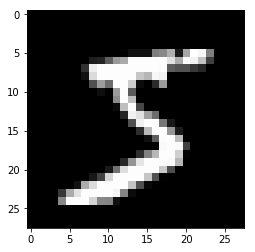

In [6]:
import matplotlib.pyplot as plt

plt.imshow(image.asnumpy()) # label : 5
plt.show()

# Multiclass logistic regression

### From scratch

In [7]:
num_inputs = 784
num_outputs = 10
num_examples = 60000

In [8]:
batch_size = 64
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle = True)
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle = False)

In [9]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

(64, 28, 28, 1) (64,)


In [10]:
# Define parameters
W = nd.random_normal(shape = (num_inputs, num_outputs), ctx = model_ctx)
b = nd.random_normal(shape = num_outputs, ctx = model_ctx)
params = [W, b]

In [11]:
for param in params:
    param.attach_grad()

In [12]:
# Define softmax activation function
def softmax(y):
    exp = nd.exp(y - nd.max(y, axis = 1).reshape((-1, 1)))
    norms = nd.sum(exp, axis = 1).reshape((-1, 1))
    return exp / norms

In [13]:
# Define model 'net'
def net(x):
    y = nd.dot(x, W) + b
    yhat = softmax(y)
    return yhat

In [14]:
# Define cross-entropy loss function
def cross_entropy(y, yhat):
    return -nd.sum(y * nd.log(yhat + 1e-6))

In [15]:
# Define SGD optimizer
def SGD(params, learning_rate):
    for param in params:
        nd.elemwise_add(-learning_rate * param.grad, param, out = param)

In [16]:
# Define accuracy metric
def evaluate_accuracy(dataset, net):
    correct = 0.
    total = 0.
    for data, label in dataset:
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        pred = nd.argmax(output, axis = 1)
        correct += nd.sum(pred == label)
        total += data.shape[0]
    return (correct / total).asscalar()

In [17]:
epochs = 10
learning_rate = 0.01

start_time = time.time()

for i in range(epochs):
    cumulative_loss = 0
    for data, label in train_data:
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()

    train_accuracy = evaluate_accuracy(train_data, net)
    test_accuracy = evaluate_accuracy(test_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % \
          (i, cumulative_loss/num_examples, train_accuracy, test_accuracy))
    
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0. Loss: 4.40526199532, Train_acc 0.736133, Test_acc 0.7341
Epoch 1. Loss: 3.6046412262, Train_acc 0.742133, Test_acc 0.7409
Epoch 2. Loss: 3.51621165072, Train_acc 0.749883, Test_acc 0.7449
Epoch 3. Loss: 3.47068470256, Train_acc 0.754133, Test_acc 0.749
Epoch 4. Loss: 3.43547365608, Train_acc 0.756983, Test_acc 0.7505
Epoch 5. Loss: 3.41347859523, Train_acc 0.7578, Test_acc 0.752
Epoch 6. Loss: 3.38642058849, Train_acc 0.756383, Test_acc 0.7513
Epoch 7. Loss: 3.37197168465, Train_acc 0.7589, Test_acc 0.7511
Epoch 8. Loss: 3.35738005021, Train_acc 0.7607, Test_acc 0.7514
Epoch 9. Loss: 3.34331607386, Train_acc 0.759867, Test_acc 0.7524
--- 146.4991009235382 seconds ---


### Using Gluon

In [18]:
del net

In [19]:
net = gluon.nn.Dense(num_outputs)
net0 = gluon.nn.Dense(num_outputs, in_units = 784)

In [20]:
print(net)
print(net.collect_params)

Dense(None -> 10, linear)
<bound method Block.collect_params of Dense(None -> 10, linear)>


In [21]:
print(net0)
print(net0.collect_params)

Dense(784 -> 10, linear)
<bound method Block.collect_params of Dense(784 -> 10, linear)>


In [22]:
# parameter initialize (standard normal dist.)
# NOT actually initialize any parameters
# Just make a note of which initializer to associate with each parameter
net.collect_params().initialize(mx.init.Normal(sigma = 1.0), ctx = model_ctx)

In [23]:
example_data = nd.random_normal(shape = (batch_size, num_inputs))
net(example_data)


[[ 36.39788055  10.23013878  -7.5571928   47.47077179  34.09246063
   11.50991631 -24.1760025    1.69304657  28.10068512  12.82897377]
 [  8.98277283 -60.89109039 -15.04196739  -7.84921455  -6.66406155
  -27.89904404   7.30398369 -37.76194763  88.00669098  -9.44850731]
 [-12.53927326  19.12228966  24.60320663  -4.40116119   3.49795532
  -15.99965954   3.34893417  -8.46943951   5.25111389  12.71951866]
 [-34.35363388  56.54007721  16.3698101    1.33660984  -7.52118301
   -4.46886539  14.86792564  52.2303009   80.30264282   0.3146534 ]
 [ -9.06959724  27.68821907 -37.49703979  15.88933563 -20.37697792
  -37.50652695 -36.64508057 -45.8342247  -20.86832047  17.66373444]
 [ 37.02320862   1.10792112  49.18914795  26.6259079   -4.20714331
   -2.13836193  13.25164986   8.5969162  -14.51876354  42.27854919]
 [ 15.37509632 -56.44948196 -38.88101196 -10.55745029 -12.51163673
  -16.66604996  28.01202393  38.92884064  14.82570171  -4.33174515]
 [-38.45901489 -44.24649811  21.15582466   0.30208349 

In [24]:
print(net.weight.data())
print(net.bias.data())


[[-2.45050359  2.84679461 -1.49613762 ...,  2.60544538 -0.50231242
  -1.03592861]
 [-0.88370675 -0.45881107  0.05414434 ...,  0.72174817  0.26860395
  -0.3811571 ]
 [ 0.83540815 -0.70175529 -0.42438081 ..., -0.6014719  -1.7975539
   0.22692102]
 ..., 
 [-0.42860946  0.60486376 -0.56944102 ..., -1.95245838 -1.35636246
   2.20442605]
 [ 2.75363064  0.37479419  0.01753719 ..., -0.87502569  0.72981817
  -0.1443232 ]
 [-1.05701315 -0.16627616 -1.39236116 ..., -1.27199733  0.26171252
   1.0708195 ]]
<NDArray 10x784 @cpu(0)>

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
<NDArray 10 @cpu(0)>


In [25]:
# Softmax cross entropy loss. Don't need softmax layer
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [26]:
# Define optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [27]:
# Define accuracy metric (use mx.metric.Accuracy)
def evaluate_accuracy(dataset, net):
    acc = mx.metric.Accuracy()
    for data, label in dataset:
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        pred = nd.argmax(output, axis=1)
        acc.update(preds = pred, labels = label)
    return acc.get()[1] # ('accuracy', 0.0953)

In [28]:
epochs = 10

start_time = time.time()

for i in range(epochs):
    cumulative_loss = 0
    for data, label in train_data:
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size) # optimizer needs data size
        cumulative_loss += nd.sum(loss).asscalar()

    train_accuracy = evaluate_accuracy(train_data, net)
    test_accuracy = evaluate_accuracy(test_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % \
          (i, cumulative_loss/num_examples, train_accuracy, test_accuracy))
    
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0. Loss: 2.04354345713, Train_acc 0.796716666667, Test_acc 0.8081
Epoch 1. Loss: 0.88397498525, Train_acc 0.835866666667, Test_acc 0.8483
Epoch 2. Loss: 0.724797618659, Train_acc 0.855033333333, Test_acc 0.8663
Epoch 3. Loss: 0.64222012802, Train_acc 0.86535, Test_acc 0.8722
Epoch 4. Loss: 0.588804508948, Train_acc 0.872383333333, Test_acc 0.8785
Epoch 5. Loss: 0.549831206934, Train_acc 0.8787, Test_acc 0.8836
Epoch 6. Loss: 0.520435121195, Train_acc 0.88145, Test_acc 0.8836
Epoch 7. Loss: 0.496468897633, Train_acc 0.885483333333, Test_acc 0.8879
Epoch 8. Loss: 0.47669046909, Train_acc 0.889116666667, Test_acc 0.8905
Epoch 9. Loss: 0.459988649201, Train_acc 0.89105, Test_acc 0.8932
--- 180.56279301643372 seconds ---


# Multilayer perceptrons

In [29]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

###  Use  `gluon.Block`

In [30]:
# Use gluon.Block
# Define forward method
class MLP(gluon.Block):
    def __init__(self, **kwargs):
        super(MLP, self).__init__(**kwargs)
        with self.name_scope():
            self.dense0 = gluon.nn.Dense(64) # or self.dense0 = gluon.nn.Dense(64, activation = 'relu')
            self.dense1 = gluon.nn.Dense(32)
            self.dense2 = gluon.nn.Dense(10)
            
    def forward(self, x):
        x = nd.relu(self.dense0(x)) 
        x = nd.relu(self.dense1(x))
        x = self.dense2(x)
        return x

In [31]:
del net
net = MLP()
net.collect_params().initialize(mx.init.Xavier(magnitude = 2.24), ctx = model_ctx)

In [32]:
print(net)

MLP(
  (dense0): Dense(None -> 64, linear)
  (dense1): Dense(None -> 32, linear)
  (dense2): Dense(None -> 10, linear)
)


In [33]:
for data, _ in train_data:
    data = data.as_in_context(model_ctx)
    break

# gluon.Block.__call__(x) is defined
# net(data) == net.forward(data)
net(data[0:1]) 


[[-0.00460785 -0.10649152  0.01577078 -0.06557376 -0.33917981 -0.08719788
   0.27524695 -0.04114221 -0.12004875 -0.08178334]]
<NDArray 1x10 @cpu(0)>

In [34]:
# loss function
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
# optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [35]:
epochs = 10

start_time = time.time()

for i in range(epochs):
    cumulative_loss = 0
    for data, label in train_data:
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        with autograd.record(): # default : train_mode = True
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()

    train_accuracy = evaluate_accuracy(train_data, net)
    test_accuracy = evaluate_accuracy(test_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % \
          (i, cumulative_loss/num_examples, train_accuracy, test_accuracy))
    
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0. Loss: 0.416298688595, Train_acc 0.93665, Test_acc 0.9355
Epoch 1. Loss: 0.181774298451, Train_acc 0.958033333333, Test_acc 0.9547
Epoch 2. Loss: 0.131911580285, Train_acc 0.969583333333, Test_acc 0.9633
Epoch 3. Loss: 0.104332525383, Train_acc 0.958883333333, Test_acc 0.9476
Epoch 4. Loss: 0.0879672529335, Train_acc 0.9711, Test_acc 0.9635
Epoch 5. Loss: 0.0759275976141, Train_acc 0.978216666667, Test_acc 0.9702
Epoch 6. Loss: 0.0651613882383, Train_acc 0.98485, Test_acc 0.9747
Epoch 7. Loss: 0.0571395777437, Train_acc 0.986383333333, Test_acc 0.9737
Epoch 8. Loss: 0.050226613236, Train_acc 0.987883333333, Test_acc 0.9742
Epoch 9. Loss: 0.0440175151316, Train_acc 0.98975, Test_acc 0.9751
--- 195.637433052063 seconds ---


### Use  `gluon.nn.Sequential`

In [36]:
# Do not need to define class
# Sequential itself subclasses Block and maintains a list of '_children'
del net

net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(64, activation="relu"))
    net.add(gluon.nn.Dropout(0.2)) # Drop 20% of activations
    net.add(gluon.nn.Dense(32, activation="relu"))
    net.add(gluon.nn.Dense(num_outputs))

In [37]:
print(net.collect_params)

<bound method Block.collect_params of Sequential(
  (0): Dense(None -> 64, Activation(relu))
  (1): Dropout(p = 0.2)
  (2): Dense(None -> 32, Activation(relu))
  (3): Dense(None -> 10, linear)
)>


### Training

In [38]:
# parameter initalize
net.collect_params().initialize(mx.init.Xavier(magnitude = 2.24), ctx = model_ctx)
# loss function
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
# optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [39]:
epochs = 10

start_time = time.time()

for i in range(epochs):
    cumulative_loss = 0
    for data, label in train_data:
        data = data.as_in_context(model_ctx).reshape((-1, 784))
        label = label.as_in_context(model_ctx)
        with autograd.record(): # default : train_mode = True
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()

    train_accuracy = evaluate_accuracy(train_data, net)
    test_accuracy = evaluate_accuracy(test_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % \
          (i, cumulative_loss/num_examples, train_accuracy, test_accuracy))
    
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0. Loss: 0.48531457847, Train_acc 0.938616666667, Test_acc 0.94
Epoch 1. Loss: 0.227102286805, Train_acc 0.956583333333, Test_acc 0.9513
Epoch 2. Loss: 0.181519980558, Train_acc 0.966216666667, Test_acc 0.9616
Epoch 3. Loss: 0.15620553847, Train_acc 0.97115, Test_acc 0.9622
Epoch 4. Loss: 0.139154357406, Train_acc 0.973283333333, Test_acc 0.9659
Epoch 5. Loss: 0.128104955886, Train_acc 0.972183333333, Test_acc 0.9652
Epoch 6. Loss: 0.118027490535, Train_acc 0.98055, Test_acc 0.974
Epoch 7. Loss: 0.113074361432, Train_acc 0.982133333333, Test_acc 0.9739
Epoch 8. Loss: 0.106842348915, Train_acc 0.981766666667, Test_acc 0.9714
Epoch 9. Loss: 0.10111082233, Train_acc 0.9837, Test_acc 0.9722
--- 218.51742911338806 seconds ---


### Custom Layer

In [40]:
class CenteredLayer(gluon.Block):
    def __init__(self, **kwargs):
        super(CenteredLayer, self).__init__(**kwargs)

    def forward(self, x):
        return x - nd.mean(x)